In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import random
#import cv2
import os

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Changing directory to images
os.chdir("/content/drive/MyDrive/Data Analysis Bootcamp")

In [ ]:
# Check Classes 
image_names=list(os.listdir("Resources/Images/Database"))
image_names.sort()
print(image_names)
class_number = len(image_names)

['Covid', 'No_Finding', 'Pneumonia']


In [ ]:
# Directory with Atelectasis
atele_dir=os.path.join("Resources/Images/Database/Covid")
df =pd.DataFrame.from_records({"file_name":os.listdir(atele_dir),"condition": "Covid"})
for f in image_names[1:]:
    folder_path="Resources/Images/Database/" + f
    temp_df= pd.DataFrame.from_records({"file_name":os.listdir(folder_path),"condition": f })
    df=df.append(temp_df)
    
df["condition"].value_counts()

Covid         184
No_Finding    151
Pneumonia     118
Name: condition, dtype: int64

In [ ]:
#Exporting Label CSV
#df.to_csv("Labels.csv")

In [ ]:
# balance classes - random Random Sampling No_Finding
#df_no_finding = df[df["condition"]=="No_Finding"].sample(n=150, random_state=42)
#df_balanced = df[df["condition"]!="No_Finding"].append(df_no_finding)
#df_balanced["condition"].value_counts()

In [ ]:
#df_balanced["file_name"] = "Resources/Images/Classes/"+df_balanced["file_name"]

In [ ]:
# Settings
batch_size = 16
img_height, img_width = 256,256

In [ ]:
data_dir = "Resources/Images/Database/"

# Rescale images 
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2)

# Flow training images in batches of batch_size using train_data 
train_ds= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= image_names,
                shuffle=True, 
                seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3)

val_ds=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= image_names,
                class_mode="categorical", 
                subset="validation", 
                shuffle=True, 
                seed=30)

Found 318 images belonging to 3 classes.
Found 135 images belonging to 3 classes.


In [ ]:
#data_dir = "Resources/Images/Classes/"
#train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#  data_dir,
#  validation_split=0.2,
#  subset="training",
#  seed=123,
#  image_size=(img_height, img_width),
#  batch_size=batch_size)

In [ ]:
#val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#  data_dir,
#  validation_split=0.2,
#  subset="validation",
#  seed=123,
#  image_size=(img_height, img_width),
#  batch_size=batch_size)

Epoch 1/10
20/20 [==============================] - 13s 659ms/step - loss: 1.1478 - accuracy: 0.3836 - val_loss: 1.1440 - val_accuracy: 0.4074
Epoch 2/10
20/20 [==============================] - 13s 646ms/step - loss: 1.1458 - accuracy: 0.4057 - val_loss: 1.1440 - val_accuracy: 0.4074
Epoch 3/10
20/20 [==============================] - 13s 627ms/step - loss: 1.1458 - accuracy: 0.4057 - val_loss: 1.1440 - val_accuracy: 0.4074
Epoch 4/10
20/20 [==============================] - 12s 624ms/step - loss: 1.1458 - accuracy: 0.4057 - val_loss: 1.1440 - val_accuracy: 0.4074
Epoch 5/10
20/20 [==============================] - 12s 622ms/step - loss: 1.1458 - accuracy: 0.4057 - val_loss: 1.1440 - val_accuracy: 0.4074
Epoch 6/10
20/20 [==============================] - 13s 634ms/step - loss: 1.1458 - accuracy: 0.4057 - val_loss: 1.1440 - val_accuracy: 0.4074
Epoch 7/10
20/20 [==============================] - 13s 628ms/step - loss: 1.1458 - accuracy: 0.4057 - val_loss: 1.1440 - val_accuracy: 0.4074

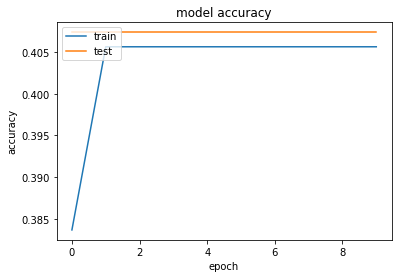

In [ ]:
with tf.device('/device:GPU:0'):
  model = tf.keras.Sequential([
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Dense(img_height, activation='relu'),
                               Flatten(),
                               Dense(class_number, activation='softmax')
                               ])
  model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
  )

  history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  verbose=1
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
with tf.device('/device:GPU:0'):
  VGG16_model = tf.keras.Sequential([
                                     VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3))),
                                     MaxPooling2D(),
                                     Dense(img_height, activation='relu'),
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])

  VGG16_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  VGG16_model_history = VGG16_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=50,
      verbose=1
      )
  plt.plot(VGG16_model_history.history['accuracy'])
  plt.plot(VGG16_model_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

Epoch 1/50
20/20 [==============================] - 14s 714ms/step - loss: 1.2257 - accuracy: 0.3176 - val_loss: 1.2181 - val_accuracy: 0.3333
Epoch 2/50
20/20 [==============================] - 14s 690ms/step - loss: 1.2181 - accuracy: 0.3333 - val_loss: 1.2181 - val_accuracy: 0.3333
Epoch 3/50
20/20 [==============================] - 14s 684ms/step - loss: 1.2181 - accuracy: 0.3333 - val_loss: 1.2181 - val_accuracy: 0.3333
Epoch 4/50
20/20 [==============================] - 14s 676ms/step - loss: 1.2181 - accuracy: 0.3333 - val_loss: 1.2181 - val_accuracy: 0.3333
Epoch 5/50
20/20 [==============================] - 14s 680ms/step - loss: 1.2181 - accuracy: 0.3333 - val_loss: 1.2181 - val_accuracy: 0.3333
Epoch 6/50
20/20 [==============================] - 13s 672ms/step - loss: 1.2181 - accuracy: 0.3333 - val_loss: 1.2181 - val_accuracy: 0.3333
Epoch 7/50
20/20 [==============================] - 14s 678ms/step - loss: 1.2181 - accuracy: 0.3333 - val_loss: 1.2181 - val_accuracy: 0.3333

KeyboardInterrupt: ignored

In [ ]:
with tf.device('/device:GPU:0'):
  ResNet50_model = tf.keras.Sequential([
                                     ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3))),
                                     MaxPooling2D(),
                                     Dense(img_height, activation='relu'),
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])

  ResNet50_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  ResNet50_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=50,
      verbose=1
      ),guijhyhujio,.ñ,gygyuigfyyygfsq4qdrftvybvtsfrdrdq222222